<a href="https://colab.research.google.com/github/hfoffani/HF-fastai/blob/main/iula_blurr_highapi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq transformers tqdm
!pip install -Uqq ohmeow-blurr
# !pip install -Uqq wandb

     |████████████████████████████████| 2.6 MB 4.3 MB/s 
     |████████████████████████████████| 76 kB 3.0 MB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
     |████████████████████████████████| 636 kB 34.1 MB/s 
     |████████████████████████████████| 895 kB 34.6 MB/s 
     |████████████████████████████████| 75 kB 2.5 MB/s 
     |████████████████████████████████| 1.2 MB 22.0 MB/s 
     |████████████████████████████████| 264 kB 50.5 MB/s 
     |████████████████████████████████| 188 kB 47.4 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 243 kB 47.0 MB/s 
     |████████████████████████████████| 118 kB 47.0 MB/s 


In [2]:
import os
import glob
import pandas as pd

from blurr.modeling.core import BlearnerForSequenceClassification

from fastai.text.all import *

### Leer Corpus

In [4]:
co_df = pd.read_csv('/content/drive/MyDrive/iula-es.csv')
num_labels = co_df['label'].nunique()
co_df

,label,sentence,is_valid
0,economía,LOS POSTULADOS DE LA ECONOMÍA CLÁSICA,True
1,economía,"La mayor parte de los tratados sobre la teoría del valor y de la producción se refieren, en primer término, a la distribución de un volumen dado de recursos empleados en diferentes usos, y a las condiciones que, supuesta la ocupación de esta cantidad de recursos, determinen su remuneración relativa y el relativo valor de sus productos [1]",False
2,economía,"También se ha sujetado con frecuencia a un procedimiento descriptivo lo relativo al monto de los recursos disponibles (entendiendo por tales el volumen de población susceptible de tomar empleo), los límites de la riqueza natural y el equipo de producción acumulado; pero rara vez se ha examinado detenidamente en la teoría pura, la explicación de lo que determina la ocupación real de los recursos disponibles.",False
3,economía,"Decir que no se ha considerado en absoluto, seria absurdo, por supuesto; porque todo estudio sobre los altibajos de la ocupación, que han sido muchos, ha tenido que ver con el tema.",False
4,economía,"No quiero decir que se haya pasado por alto, sino que la teoría fundamental en que descansa se ha creído tan sencilla y evidente que casi no había para qué mencionarla [2]",False
...,...,...,...
52350,medicina,Diarrea.,True
52351,medicina,Debilidad.,False
52352,medicina,Gusto alterado.,False
52353,medicina,Parestesias peribucales.,False


### Modelar

In [ ]:

# pretrained_model_name = "distilbert-base-uncased"
# pretrained_model_name = "bert-base-uncased"
# pretrained_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
pretrained_model_name = "distilroberta-base"

In [ ]:
dl_kwargs = {'bs': 4, 'val_bs': 8}
learn_kwargs = { 'metrics': [F1Score(average=None)] }

learn = BlearnerForSequenceClassification.from_dataframe(
    co_df, pretrained_model_name, 
    text_attr='sentence', label_attr='label',
    dblock_splitter=ColSplitter(),
    dl_kwargs=dl_kwargs, learner_kwargs=learn_kwargs)

learn = learn.to_fp16()


In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 343 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

### Entrenar

SuggestedLRs(valley=0.0006918309954926372)

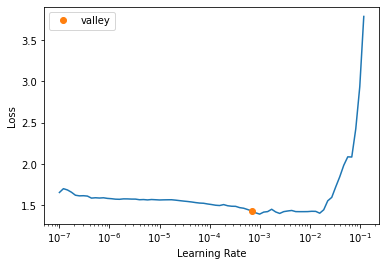

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,f1_score,time
0,0.368966,0.407265,[0.69129917 0.66630137 0.6961326 0.9003424 0.86298701],20:28


In [ ]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"Quedan reservadas, en todo caso, a las Fuerzas y Cuerpos de Seguridad del Estado bajo la dependencia del Gobierno los servicios policiales de carácter extracomunitario y supracomunitario como la vigilancia de puertos, aeropuertos, costas y fronteras, aduanas, control de entrada y salida del territorio nacional de españoles y extranjeros, régimen general de extranjería, extradición y expulsión, emigración e inmigración, pasaportes, documento nacional de identidad, trafico, armas y explosivos, resguardo fiscal del Estado, contrabando y fraude fiscal y las demás funciones que directamente les encomienda el artículo 104 de la Constitución [19] y las que les atribuya la Ley orgánica que lo desarrolle.",legal,legal
1,"- La farmacovigilancia: desarrollo de redes de vigilancia para la detección precoz de los posibles efectos secundarios de los nuevos medicamentos, de acuerdo con el marco reglamentario existente y prestando una atención especial a los esfuerzos internacionales de armonización. Esta investigación comprenderá el estudio de la exposición de los pacientes a los medicamentos, la armonización de los términos y los criterios diagnósticos, el análisis de los signos de efectos secundarios potenciales, el análisis de las estadísticas de morbilidad y mortalidad, estudios transnacionales de control de casos, registros transnacionales y estudios de cohorte.",medicina,medicina
2,"Si el lector objeta que, a la larga, un individuo experimentado y no perturbado por el pasatiempo debe poder ganar grandes sumas a los otros jugadores, si sigue comprando inversiones de acuerdo con sus expectativas más perfectas a largo plazo, podría objetársele, ante todo, que hay, en verdad, individuos de mentalidad tan seria como ésta, y que un mercado de inversión será muy diferente según que la influencia de esta gente seria predomine o no sobre la opinión de los jugadores.",economia,economia
3,"c Si el número de operaciones realizadas para un vencimiento no alcanzara al doble de las cantidades establecidas en los apartados a) y b) anteriores, el precio al cierre será el que resulte de la media entre el mejor precio de oferta y el mejor precio de demanda al cierre y si no hubiera mejor precio de oferta y demanda o faltara uno de ellos, se tomará el precio de cierre de la sesión anterior.",economia,economia
4,"A los efectos de la liquidación al vencimiento, el precio se fijará del siguiente modo: Se restará de la base 100,00 el tipo de interés para la liquidación de FRA a tres meses el día del vencimiento del futuro, redondeado al alza a dos decimales, calculado y publicado por el Banco de España según lo establecido en el ""Manual del Servicio Telefónico del Mercado de Dinero del Banco de España"".",economia,economia


### Evaluar

In [ ]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'f1_score': array([0.69129917, 0.66630137, 0.6961326 , 0.9003424 , 0.86298701]),
 'loss': 0.4072648584842682}

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([10471, 5]) torch.Size([10471]) torch.Size([10471])
TensorBase(0.4073) TensorBase(0.8504)


### Infererir

In [ ]:
learn.export('iula_learner.pkl')

In [ ]:
inf_learn = load_learner('iula_learner.pkl')

In [ ]:
inf_learn.blurr_predict(pd.DataFrame([
    {'sentence': 'Según el BCE la inflación en el próximo año será menor al 2%'},
    {'sentence': 'La cardiopatía congénita es tratable vía transplante'},
    {'sentence': 'Altos niveles de CO2 durante la calima.'},
    {'sentence': 'Las partículas de 20 micrones pueden producir neumonías.'},
]))

[(('economia',),
  (#1) [tensor(1)],
  (#1) [tensor([0.1580, 0.7298, 0.0026, 0.1047, 0.0048])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([1.5389e-03, 4.1685e-04, 1.2403e-05, 9.9548e-01, 2.5520e-03])]),
 (('ambiente',),
  (#1) [tensor(0)],
  (#1) [tensor([9.5956e-01, 5.9777e-03, 3.9023e-04, 2.5960e-02, 8.1099e-03])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([0.0954, 0.0089, 0.0017, 0.8247, 0.0693])])]